In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [49]:
lang = "en"

In [50]:
df_comb = pd.read_excel("../files/input/combined_data.xlsx")

In [51]:
df_comb.head()

,person,content
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a..."
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...
3,Will Smith,"Willard Carroll Smith II (born September 25, ..."
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...


In [52]:
## lang detect python

In [53]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

df_comb["actual_lang"] = df_comb["content"].apply(detect)

In [54]:
## add this comment to code

a = df_comb[df_comb["actual_lang"]=="en"]
a[a.duplicated('person')]

,person,content,actual_lang
55,Kamal Haasan,"Kamal Haasan (Ramanathapuram, 7 novembre 1954)...",en
78,James Patterson,"James Patterson (Newburgh, 22 marzo 1947) è un...",en


In [55]:
df_comb.actual_lang.value_counts()

en    53
ru    51
it    49
Name: actual_lang, dtype: int64

In [56]:
## filter to required lang

In [57]:
df = df_comb[df_comb["actual_lang"] == str(lang)].reset_index(drop=True)

In [58]:
df.head()

,person,content,actual_lang
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a...",en
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...,en
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...,en
3,Will Smith,"Willard Carroll Smith II (born September 25, ...",en
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...,en


In [59]:
import warnings
warnings.filterwarnings('ignore')
lang_models = {"en": spacy.load("en_core_web_md"), "it": spacy.load("it_core_news_md"), "ru": spacy.load("ru_core_news_md")}

In [60]:
# Our spaCy model:
nlp = lang_models[str(lang)]
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['content']):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

In [61]:
df['tokens'] = tokens
df['tokens'][:3]

0    [george, timothy, clooney, bear, american, act...
1    [shah, rukh, khan, pronounce, ˈʃɑːɦɾʊx, xɑːn, ...
2    [leonardo, wilhelm, dicaprio, italian, diˈkaːp...
Name: tokens, dtype: object

In [62]:
df.head()

,person,content,actual_lang,tokens
0,George Clooney,"George Timothy Clooney (born May 6, 1961) is a...",en,"[george, timothy, clooney, bear, american, act..."
1,Shah Rukh Khan,Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn]; bo...,en,"[shah, rukh, khan, pronounce, ˈʃɑːɦɾʊx, xɑːn, ..."
2,Leonardo DiCaprio,Leonardo Wilhelm DiCaprio (; Italian: [diˈkaːp...,en,"[leonardo, wilhelm, dicaprio, italian, diˈkaːp..."
3,Will Smith,"Willard Carroll Smith II (born September 25, ...",en,"[willard, carroll, smith, ii, bear, september,..."
4,Kamal Haasan,Kamal Haasan (born 7 November 1954) is an Indi...,en,"[kamal, haasan, bear, november, indian, actor,..."


In [63]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df['tokens'])

In [64]:
print(dictionary.token2id)

{'abc': 0, 'abraham': 1, 'abramoff': 2, 'abrupt': 3, 'absence': 4, 'abuse': 5, 'academy': 6, 'accept': 7, 'acceptance': 8, 'accident': 9, 'acclaim': 10, 'accolade': 11, 'accord': 12, 'account': 13, 'accuse': 14, 'achievement': 15, 'act': 16, 'acting': 17, 'action': 18, 'activism': 19, 'activist': 20, 'activity': 21, 'actor': 22, 'actors': 23, 'actress': 24, 'ada': 25, 'adapt': 26, 'adaptation': 27, 'adaption': 28, 'additional': 29, 'adelia': 30, 'adopt': 31, 'adultery': 32, 'adventure': 33, 'advisor': 34, 'advocacy': 35, 'advocate': 36, 'affleck': 37, 'affordable': 38, 'afi': 39, 'age': 40, 'agency': 41, 'agent': 42, 'aid': 43, 'aim': 44, 'air': 45, 'al': 46, 'alamuddin': 47, 'alert': 48, 'alexander': 49, 'alfonso': 50, 'alive': 51, 'allen': 52, 'alliance': 53, 'allied': 54, 'altar': 55, 'amal': 56, 'amazon': 57, 'amc': 58, 'america': 59, 'american': 60, 'ancestry': 61, 'anchorman': 62, 'anderson': 63, 'andrei': 64, 'andrew': 65, 'andy': 66, 'angela': 67, 'angele': 68, 'angeles': 69, '

In [65]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [66]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

In [67]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 19), (10, 5), (11, 1), (12, 3), (13, 2), (14, 1), (15, 2), (16, 2), (17, 2), (18, 1), (19, 2), (20, 3), (21, 3), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 2), (28, 2), (29, 2), (30, 3), (31, 4), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 8), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 5), (53, 1), (54, 2), (55, 7), (56, 4), (57, 2), (58, 1), (59, 1), (60, 1), (61, 3), (62, 1), (63, 3), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 2), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 18), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 4), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 2), (98, 2), (99, 1), (100, 2), (101, 1), (102, 2), (103, 1), (104, 4), (105, 1), (106, 1), (107, 6), (108, 1), (109, 1), (110, 

In [72]:
# set baseline model
lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=10, 
                       random_state=100,
                       iterations=100,
                       chunksize=100,
                       passes=10,
                       per_word_topics=True)

In [74]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"king" + 0.045*"rock" + 0.028*"novel" + 0.019*"publish" + '
  '0.015*"match" + 0.013*"championship" + 0.012*"character" + 0.011*"episode" '
  '+ 0.008*"football" + 0.007*"read"'),
 (1,
  '0.071*"india" + 0.046*"page" + 0.034*"indian" + 0.027*"score" + '
  '0.023*"match" + 0.021*"test" + 0.012*"romance" + 0.011*"ceo" + '
  '0.010*"average" + 0.009*"century"'),
 (2,
  '0.089*"defeat" + 0.057*"match" + 0.056*"grand" + 0.038*"french" + '
  '0.031*"court" + 0.026*"ranking" + 0.026*"round" + 0.025*"season" + '
  '0.022*"double" + 0.019*"era"'),
 (3,
  '0.061*"clinton" + 0.033*"obama" + 0.023*"law" + 0.021*"election" + '
  '0.015*"presidential" + 0.011*"bill" + 0.010*"political" + 0.009*"health" + '
  '0.009*"vote" + 0.009*"hillary"'),
 (4,
  '0.061*"season" + 0.058*"player" + 0.057*"score" + 0.053*"goal" + '
  '0.050*"match" + 0.035*"league" + 0.021*"defeat" + 0.021*"finish" + '
  '0.020*"cup" + 0.016*"injury"'),
 (5,
  '0.074*"album" + 0.045*"song" + 0.042*"music" + 0.024*"art

In [77]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.275260341768894

Coherence Score:  0.6319957843945441


Running iteration number 1
Running iteration number 2
Running iteration number 3
Running iteration number 4
Running iteration number 5
Running iteration number 6
Running iteration number 7
Running iteration number 8
Running iteration number 9


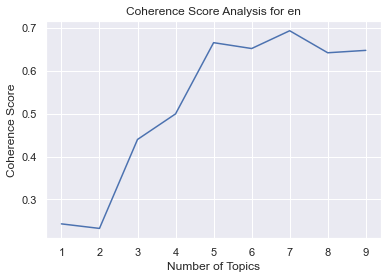

In [69]:
topics = []
score = []
for i in range(1,10,1):
    print("Running iteration number " + str(i))
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=100, chunksize=100)
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score Analysis for ' + str(lang))
fig.patch.set_facecolor('white')
plt.show()
fig.savefig("../files/output/" + str(lang) + "/coherence_score_" + str(lang) + ".png", bbox_inches='tight')

In [78]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
import gensim
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)                
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_en.csv', index=False)
    pbar.close()

  6%|██▌                                       | 33/540 [03:23<54:22,  6.43s/it]

In [70]:
num_topics = topics[score.index(max(score))]
num_topics

7

In [273]:
print("Number of topics with highest coherence score for " + str(lang) + " model is: " + str(num_topics))

Number of topics with highest coherence score for ru model is: 5


In [274]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=num_topics, workers = 4, passes=100)

In [275]:
lda_model.print_topics(-1)

[(0,
  '0.020*"президент" + 0.018*"трамп" + 0.014*"билл" + 0.010*"выбор" + 0.010*"россия" + 0.009*"пост" + 0.009*"млрд" + 0.008*"состояние" + 0.008*"дональд" + 0.008*"партия"'),
 (1,
  '0.071*"альбом" + 0.038*"песня" + 0.032*"сингл" + 0.025*"выпустить" + 0.016*"billboard" + 0.014*"музыкальный" + 0.013*"чарт" + 0.010*"записать" + 0.010*"you" + 0.009*"музыка"'),
 (2,
  '0.069*"турнир" + 0.036*"финал" + 0.036*"чемпионат" + 0.032*"открытый" + 0.032*"выиграть" + 0.028*"матч" + 0.022*"сезон" + 0.020*"победить" + 0.020*"рейтинг" + 0.020*"проиграть"'),
 (3,
  '0.025*"роман" + 0.016*"кинг" + 0.012*"мужской" + 0.011*"актёр" + 0.010*"написать" + 0.010*"золотой" + 0.008*"писать" + 0.008*"серия" + 0.008*"сняться" + 0.008*"of"'),
 (4,
  '0.053*"матч" + 0.035*"сезон" + 0.032*"чемпион" + 0.027*"выиграть" + 0.025*"команда" + 0.023*"лига" + 0.022*"чемпионат" + 0.020*"рекорд" + 0.017*"клуб" + 0.015*"счёт"')]

In [276]:
# set sort_topics to be False to ensure same order as gensim model
# thing to take note of is that gensim starts from 0, pyldavis starts from 1
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, "../files/output/" + str(lang) + "/lda_" + str(lang) + ".html")

In [277]:
df.head()

,person,content,actual_lang,tokens
0,"Клуни, Джордж",Джордж Ти́моти Клу́ни (англ. George Timothy Cl...,ru,"[джордж, англ, george, timothy, clooney, род, ..."
1,"Хан, Шахрух","Ша́хрух Хан (хинди शाहरुख़ ख़ान, урду شاہ رخ خ...",ru,"[хан, хинди, урд, شاہ, رخ, англ, shah, rukh, k..."
2,"Ди Каприо, Леонардо",Леона́рдо Вильге́льм Ди Ка́прио (англ. Leonard...,ru,"[ди, англ, leonardo, wilhelm, dicaprio, род, н..."
3,"Смит, Уилл",Уи́ллард Кэ́рролл (Уи́лл) Смит Второй (англ. W...,ru,"[смит, второй, англ, willard, carroll, will, s..."
4,Камал Хасан,"Камал Хасан (англ. Kamal Haasan, там. கமல்ஹாசன...",ru,"[камал, хасан, англ, kamal, haasan, хинди, род..."


In [278]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=df['tokens']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, df], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic = pd.concat([df,df_dominant_topic], axis=1)
df_dominant_topic

,person,content,actual_lang,tokens,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,"Клуни, Джордж",Джордж Ти́моти Клу́ни (англ. George Timothy Cl...,ru,"[джордж, англ, george, timothy, clooney, род, ...",3,0.8857,"роман, кинг, мужской, актёр, написать, золотой..."
1,"Хан, Шахрух","Ша́хрух Хан (хинди शाहरुख़ ख़ान, урду شاہ رخ خ...",ru,"[хан, хинди, урд, شاہ, رخ, англ, shah, rukh, k...",3,0.9420,"роман, кинг, мужской, актёр, написать, золотой..."
2,"Ди Каприо, Леонардо",Леона́рдо Вильге́льм Ди Ка́прио (англ. Leonard...,ru,"[ди, англ, leonardo, wilhelm, dicaprio, род, н...",3,0.9991,"роман, кинг, мужской, актёр, написать, золотой..."
3,"Смит, Уилл",Уи́ллард Кэ́рролл (Уи́лл) Смит Второй (англ. W...,ru,"[смит, второй, англ, willard, carroll, will, s...",3,0.8255,"роман, кинг, мужской, актёр, написать, золотой..."
4,Камал Хасан,"Камал Хасан (англ. Kamal Haasan, там. கமல்ஹாசன...",ru,"[камал, хасан, англ, kamal, haasan, хинди, род...",3,0.9882,"роман, кинг, мужской, актёр, написать, золотой..."
5,"Круз, Том","Том Круз (англ. Tom Cruise, полное имя Томас К...",ru,"[круз, англ, tom, cruise, полный, имя, томас, ...",3,0.9983,"роман, кинг, мужской, актёр, написать, золотой..."
6,"Джонсон, Дуэйн",Дуэ́йн Ду́глас Джо́нсон (англ. Dwayne Douglas ...,ru,"[англ, dwayne, douglas, johnson, род, май, год...",4,0.6891,"матч, сезон, чемпион, выиграть, команда, лига,..."
7,"Питт, Брэд",Уи́льям Брэ́дли Питт (англ. William Bradley Pi...,ru,"[питт, англ, william, bradley, pitt, род, дека...",3,0.9984,"роман, кинг, мужской, актёр, написать, золотой..."
8,"Депп, Джонни",Джон Кри́стофер (Джо́нни) Депп II (англ. John ...,ru,"[джон, депп, ii, англ, john, christopher, john...",3,0.9293,"роман, кинг, мужской, актёр, написать, золотой..."
9,"Фримен, Морган",Мо́рган Фри́мен (англ. Morgan Freeman; род. 1 ...,ru,"[англ, morgan, freeman, род, июнь, мемфис, тен...",3,0.9153,"роман, кинг, мужской, актёр, написать, золотой..."


In [279]:
writer = pd.ExcelWriter('../files/output/' +str(lang) + '/topic_modelling_output_' + str(lang) + '.xlsx' , engine='xlsxwriter')
workbook = writer.book
workbook.formats[0].set_font_size(12)
df_dominant_topic.to_excel(writer, sheet_name = 'Output', index=False)

for idx, col in enumerate(df_dominant_topic):  # loop through all columns
    series = df_dominant_topic[col]
    max_len = 20
    writer.sheets['Output'].set_column(idx, idx, max_len)  # set column width
    
writer.close()

/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/bhaveshchainani/virtualenv/proofpoint_code/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im